# Explore Data:

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

from src.preprocessing import preprocess_data
from src.features import create_features
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor,HistGradientBoostingRegressor

from src.modeling import (train_linear_regression,
                          train_random_forest,
                          train_hist_gradient_boosting,
                          predict,
                          feature_importance)
from src.evaluation import regression_metrics,compare_models, plot_residuals

pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")


In [5]:
# Load the dataset
df_raw = pd.read_csv("../data/raw/amazon_sales.csv")
df_clean = preprocess_data(df_raw)
df_eda = df_clean.copy()
df_features = create_features(df_clean)




In [6]:
df_features.head()
df_features.info()

<class 'pandas.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   price                            50000 non-null  float64
 1   discount_percent                 50000 non-null  int64  
 2   rating                           50000 non-null  float64
 3   review_count                     50000 non-null  int64  
 4   total_revenue                    50000 non-null  float64
 5   order_month                      50000 non-null  int32  
 6   order_year                       50000 non-null  int32  
 7   product_category_Books           50000 non-null  bool   
 8   product_category_Electronics     50000 non-null  bool   
 9   product_category_Fashion         50000 non-null  bool   
 10  product_category_Home & Kitchen  50000 non-null  bool   
 11  product_category_Sports          50000 non-null  bool   
 12  customer_region_Europe       

## Baseline Model(Linear Regression):

In [7]:
TARGET = "total_revenue"
X = df_features.drop(columns=[TARGET])
y = df_features[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [8]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred_lr = lin_reg.predict(X_test)

In [9]:
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print('Linear Regression Metrics')
print('MAE :', mae_lr)
print('RMSE :', rmse_lr)
print('R2 :', r2_lr)

Linear Regression Metrics
MAE : 270.1420850089096
RMSE : 359.0528936784566
R2 : 0.5245323291015918


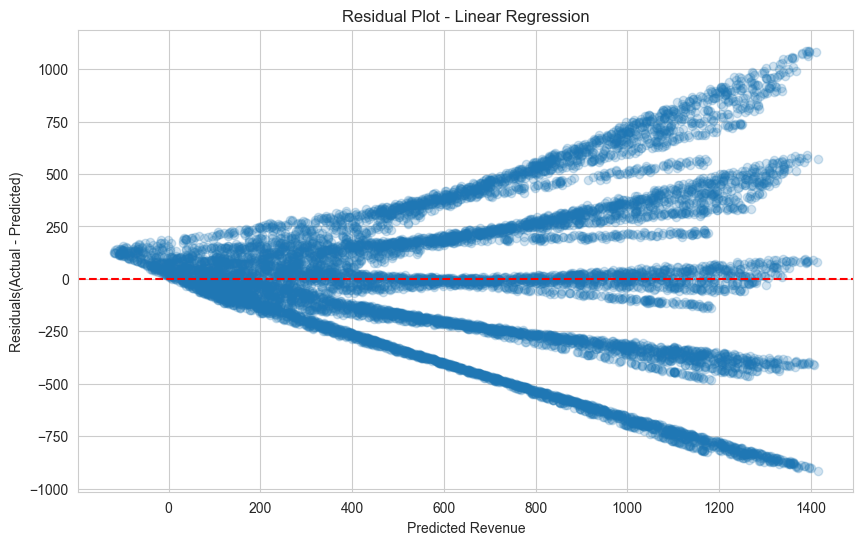

In [10]:
residuals = y_test - y_pred_lr
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_lr, residuals, alpha=0.2)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Revenue')
plt.ylabel('Residuals(Actual - Predicted)')
plt.title('Residual Plot - Linear Regression')
plt.show()

## Tree Based Model(Random Forest):

In [12]:
rf = RandomForestRegressor(n_estimators=200, 
                           random_state=42,
                             n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)


In [13]:
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print('Random Forest Regression Metrics')
print('MAE :', mae_rf)
print('RMSE :', rmse_rf)
print('R2 :', r2_rf)


Random Forest Regression Metrics
MAE : 273.295323085
RMSE : 366.93409162921523
R2 : 0.5034302521995281


In [14]:
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

importances.head(10)

price                            0.616014
review_count                     0.101196
rating                           0.075169
order_month                      0.051466
discount_percent                 0.037670
order_year                       0.011631
customer_region_Middle East      0.009378
customer_region_Europe           0.009330
customer_region_North America    0.009203
payment_method_Wallet            0.009099
dtype: float64

## Compare Models:

In [15]:
comparison = pd.DataFrame({'Model': ['Linear Regression', 'Random Forest'],
                           'MAE': [mae_lr, mae_rf],
                            'RMSE': [rmse_lr, rmse_rf],
                            'R2': [r2_lr, r2_rf]})
comparison

,Model,MAE,RMSE,R2
0,Linear Regression,270.142085,359.052894,0.524532
1,Random Forest,273.295323,366.934092,0.503430


## Linear Regression (Log-Transform)

In [16]:
y_log = np.log1p(y)

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

lin_reg_log = LinearRegression()
lin_reg_log.fit(X_train_log, y_train_log)

y_pred_log = lin_reg_log.predict(X_test_log)

y_pred_log_exp = np.expm1(y_pred_log)

mae_log = mean_absolute_error(y_test, y_pred_log_exp)
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log_exp))
r2_log = r2_score(y_test, y_pred_log_exp)

print('Linear Regression (Log-Transform) Metrics')
print('MAE :', mae_log)
print('RMSE :', rmse_log)
print('R2 :', r2_log)


Linear Regression (Log-Transform) Metrics
MAE : 294.75041317959574
RMSE : 397.38063780623116
R2 : 0.4176051373141306


## Gradient Boosting Regressor:

In [19]:
gbr = HistGradientBoostingRegressor(max_depth= 6,
                                    learning_rate= 0.05,
                                    random_state= 42)

gbr.fit(X_train, y_train)

y_pred_gbr = gbr.predict(X_test)

mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
r2_gbr = r2_score(y_test, y_pred_gbr)

print('Histogram-based Gradient Boosting (GBR) Metrics')
print('MAE :', mae_gbr)
print('RMSE :', rmse_gbr)
print('R2 :', r2_gbr)


Histogram-based Gradient Boosting (GBR) Metrics
MAE : 265.36504253020956
RMSE : 358.2044583516606
R2 : 0.5267767168130348


## Model Comparisons:

In [20]:
comparison = pd.DataFrame({'Model': ['Linear Regression', 'Random Forest', 'Linear Regression (Log-Transform)', 'Gradient Boosting Regressor'],
                           'MAE': [mae_lr, mae_rf, mae_log, mae_gbr],
                            'RMSE': [rmse_lr, rmse_rf, rmse_log, rmse_gbr],
                            'R2': [r2_lr, r2_rf, r2_log, r2_gbr]})
comparison

,Model,MAE,RMSE,R2
0,Linear Regression,270.142085,359.052894,0.524532
1,Random Forest,273.295323,366.934092,0.503430
2,Linear Regression (Log-Transform),294.750413,397.380638,0.417605
3,Gradient Boosting Regressor,265.365043,358.204458,0.526777


## Model Functions:

In [22]:
results = {}

# Linear Regression
lr = train_linear_regression(X_train, y_train)
y_pred_lr = predict(lr, X_test)
results["Linear Regression"] = regression_metrics(y_test, y_pred_lr)

# Random Forest
rf = train_random_forest(X_train, y_train)
y_pred_rf = predict(rf, X_test)
results["Random Forest"] = regression_metrics(y_test, y_pred_rf)

# Gradient Boosting (your winner)
gbr = train_hist_gradient_boosting(X_train, y_train)
y_pred_gbr = predict(gbr, X_test)
results["Gradient Boosting Regressor"] = regression_metrics(y_test, y_pred_gbr)

comparison_df = compare_models(results)
comparison_df


,Model,MAE,RMSE,R2
0,Gradient Boosting Regressor,265.365043,358.204458,0.526777
1,Linear Regression,270.142085,359.052894,0.524532
2,Random Forest,273.295323,366.934092,0.503430


In [25]:
comparison_df.to_csv(
    "../data/processed/model_comparison.csv",
    index=False
)


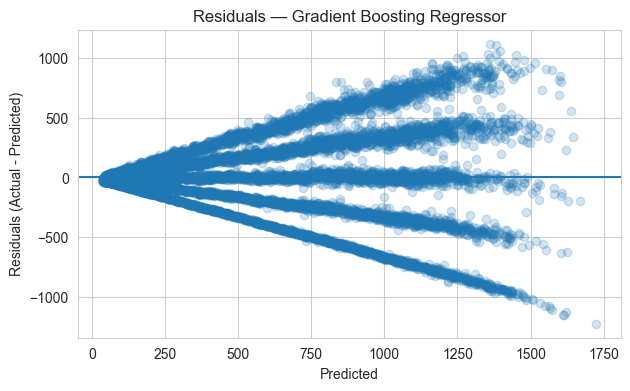

In [23]:
plot_residuals(y_test, y_pred_gbr, title="Residuals — Gradient Boosting Regressor")


In [24]:
imp = feature_importance(rf, X.columns)
imp.head(10)


price                            0.616014
review_count                     0.101196
rating                           0.075169
order_month                      0.051466
discount_percent                 0.037670
order_year                       0.011631
customer_region_Middle East      0.009378
customer_region_Europe           0.009330
customer_region_North America    0.009203
payment_method_Wallet            0.009099
dtype: float64